In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Data/Hourly consumtpion per cluster London.csv")
df["time"] = df["time"].astype(str).str.zfill(3)
df.index = df["time"]
df["day"] = df["time"].str[:1]
df["hour"] = df["time"].str[1:]
df.drop(['time','Unnamed: 0'], axis = 1, inplace = True)




,consumption_kWh,hour,CO2_intensity
time,,,
000,587.238769,0,206.339623
001,487.561051,1,214.980769
002,413.403647,2,214.673077
003,378.318955,3,215.509615
004,367.642231,4,216.461538


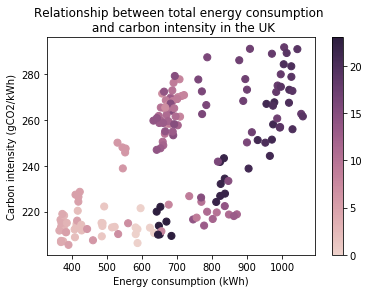

In [3]:
a = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()

a['hour'] = a.index.str[1:].astype(int)


z = df.iloc[range(0,168),-3]
a["CO2_intensity"] = z


cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(a['consumption_kWh'], y = a['CO2_intensity'], c=a['hour'], s=50, cmap=cmap)
f.colorbar(points)


plt.title("Relationship between total energy consumption \n and carbon intensity in the UK")
plt.xlabel("Energy consumption (kWh)")
plt.ylabel("Carbon intensity (gCO2/kWh)")

plt.savefig("Carbon Intensity vs Consumption London.png")

a.head()

### Load the best model for consumption-carbon intensity mathing 

CF London Consumption-Carbon intensity model notebook for model comparison

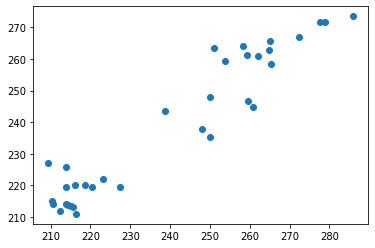

In [4]:
week = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()
week["day"] = week.index.str[:1]
week["hour"] = week.index.str[1:]

z = df.iloc[range(0,168),-3]
week["CO2_intensity"] = z

train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
rf = RandomForestRegressor(max_depth=None, min_samples_split = 2)

X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)


rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
plt.scatter(y_test,y_pred)

In [5]:
a['consumption_kWh'].corr(a['CO2_intensity'])

0.6462240151104416

## Reduction of energy consumption 

### Peak consumption reduction in cluster 5 

Evaluate the impact a X% reduction in energy consumption of a cluster during evening peak could have on overall consumption and co2 emissions. 

We look at cluster 5 between 6 and 10 pm

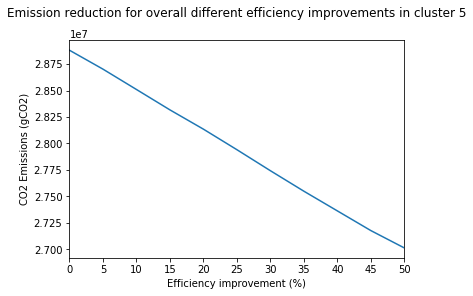

In [23]:
eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
eff["Efficiency"] = 1

for i in range(len(decrease)) : 
    
    eff["Efficiency"] = eff["Efficiency"].where(
        ((eff["hour"] != "18") & (eff["hour"] != "19") & (eff["hour"] != "20")
        & (eff["hour"] != "21") &(eff["hour"] != "22")) | (eff["Cluster"] != 4 ) , decrease[i])
    

    eff["consumption_kWh1"] = eff["consumption_kWh"]*eff["Efficiency"]
    
    a = eff.groupby(eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements in cluster 5", y = 1.08)
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)

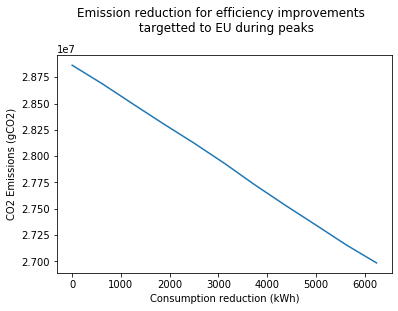

In [6]:
eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
eff["Efficiency"] = 1
saved = [None]*len(decrease)

for i in range(len(decrease)) : 
    
    eff["Efficiency"] = eff["Efficiency"].where(
        ((eff["hour"] != "18") & (eff["hour"] != "19") & (eff["hour"] != "20")
        & (eff["hour"] != "21") &(eff["hour"] != "22")) | (eff["Cluster"] != 4 ) , decrease[i])
    

    eff["consumption_kWh1"] = eff["consumption_kWh"]*eff["Efficiency"]
    saved[i] = eff["consumption_kWh"]*(1-eff["Efficiency"])

    a = eff.groupby(eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

for i in range(len(saved)): 
    saved[i] = saved[i].sum()    

plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction (kWh)")
plt.title("Emission reduction for efficiency improvements  \n targetted to EU during peaks",y=1.08)
#my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
#plt.xticks(decrease,my_xticks)
saved2 = saved
result2 = result
plt.plot(saved2,result2)
#ov_eff['CO2_intensity']


In [35]:
o.head()

,Cluster,time,consumption_kWh
0,0,000,33.813385
1,0,001,37.310308
2,0,002,29.514769
3,0,003,31.131462
4,0,004,39.650769


Emissions reductions is the most optimal for efficiency improvements of 10 to 30%. Afterwards, the effect is significantly reduced. 

### Overall Cluster 5 Improvement 

11


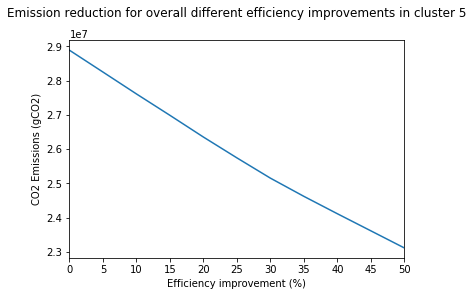

In [57]:
c5_eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))

c5_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    c5_eff["efficiency"] = c5_eff["efficiency"].where(
        c5_eff["Cluster"] != 4 , decrease[i])
    c5_eff["consumption_kWh1"] = c5_eff["consumption_kWh"]*c5_eff["efficiency"]
    a = c5_eff.groupby(c5_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements in cluster 5", y = 1.08)
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)

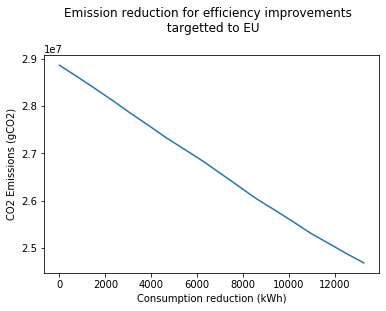

In [7]:
c5_eff = df.copy()

decrease = np.arange(1, 0.65, -0.02)
result = [None]*len(decrease)
saved = [None]*len(decrease)

c5_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    c5_eff["efficiency"] = c5_eff["efficiency"].where(
        c5_eff["Cluster"] != 4 , decrease[i])
    c5_eff["consumption_kWh1"] = c5_eff["consumption_kWh"]*c5_eff["efficiency"]
    saved[i] = c5_eff["consumption_kWh"]*(1-c5_eff["efficiency"])
    a = c5_eff.groupby(c5_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

for i in range(len(saved)): 
    saved[i] = saved[i].sum()    

plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction (kWh)")
plt.title("Emission reduction for efficiency improvements  \n targetted to EU",y=1.08)
#my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
#plt.xticks(decrease,my_xticks)
saved1 = saved
result1 = result
plt.plot(saved1,result1)
#ov_eff['CO2_intensity']


There seems to be a dip at around 25-30% efficiency improvement

### Overall efficiency improvement 

11


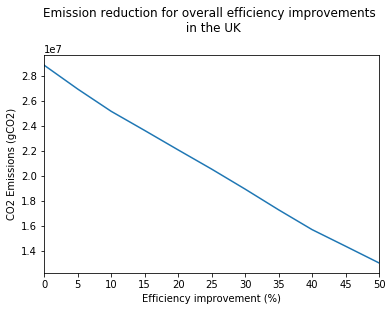

In [8]:
ov_eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))

columns = decrease

df1 = pd.DataFrame(columns = columns)

ov_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    ov_eff["efficiency"] = decrease[i]
    ov_eff["consumption_kWh1"] = ov_eff["consumption_kWh"]*ov_eff["efficiency"]
    #print(ov_eff["consumption_kWh1"])
    a = ov_eff.groupby(ov_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    result[i] = a["Emissions"].sum()
    #print(ov_eff["Emissions"].sum())

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall efficiency improvements \n in the UK",y=1.08)
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)
#ov_eff['CO2_intensity']


8


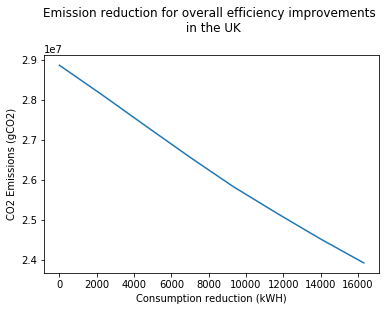

In [10]:
ov_eff = df.copy()

decrease = np.arange(1, 0.85, -0.02)
result = [None]*len(decrease)
print(len(decrease))
saved = [None]*len(decrease)

columns = decrease

df1 = pd.DataFrame(columns = columns)

ov_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    ov_eff["efficiency"] = decrease[i]
    ov_eff["consumption_kWh1"] = ov_eff["consumption_kWh"]*ov_eff["efficiency"]
    #v[i] = ov_eff["consumption_kWh1"]
    saved[i] = ov_eff["consumption_kWh"]*(1-ov_eff["efficiency"])
    a = ov_eff.groupby(ov_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    result[i] = a["Emissions"].sum()
    #print(ov_eff["Emissions"].sum())

    

for i in range(len(saved)): 
    saved[i] = saved[i].sum()    

plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction (kWH)")
plt.title("Emission reduction for overall efficiency improvements \n in the UK",y=1.08)
#my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
#plt.xticks(decrease,my_xticks)
plt.plot(saved,result)

#ov_eff['CO2_intensity']


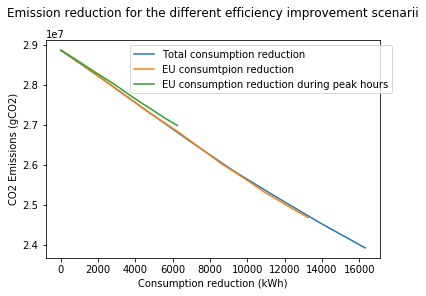

In [11]:
plt.plot(saved,result, label = 'Total consumption reduction')
plt.plot(saved1,result1, label = 'EU consumtpion reduction')
plt.plot(saved2,result2, label = 'EU consumption reduction during peak hours')
plt.title("Emission reduction for the different efficiency improvement scenarii",y=1.08)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction (kWh)")
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig("Emission reduction for the different efficiency improvement scenarii.png")


There seems to be 3 zones. Between 0 and 10% the changes is the most important, then between 10 and 40% and then after 40%. The most effective is zone 1 then zone 2 then zone 3

Do all population with small improvement rather than specific group big improvement

## Moving households from a cluster to another


Move a part of cluster 5 to cluster 2

In [38]:
len(clus)/5

168.0

Get mean consumption per cluster for each time

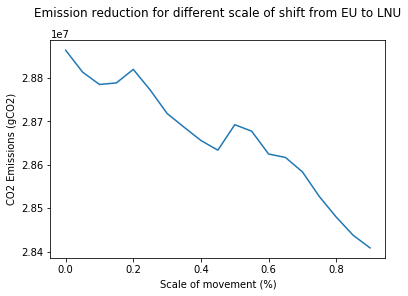

In [12]:
clus = df.copy()

move = np.arange(0, 0.95, 0.05)
result = [None]*len(move)

for i in range(len(result)): 

    c5 = clus[clus["Cluster"] == 4]

    c5["Change"] = move[i]*c5["consumption_kWh"]

    tot = c5['Change'].sum()


    c2 = clus[clus["Cluster"] == 1]
    tot_c2 = c2["consumption_kWh"].sum()

    c2["Perc"] = c2["consumption_kWh"]/tot_c2
    c2.head()
    c2["Perc"].sum()
    c2['Added'] = tot*c2["Perc"]
    c2.head()
    a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

    clus["Change"] = a

    clus["consumption_kWh1"] = clus["consumption_kWh"].where(
        clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
        clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

    a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]

    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

    result[i] = a["Emissions"].sum()

    
    
    
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Scale of movement (%)")
plt.title("Emission reduction for different scale of shift from EU to LNU",y=1.08)
plt.plot(move,result)
#ov_eff['CO2_intensity']

Cluster 4 to 2

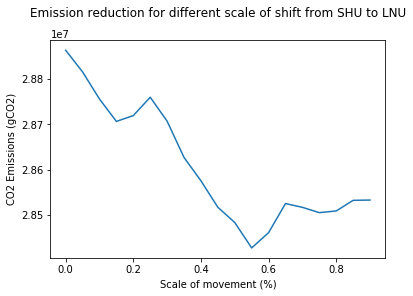

In [13]:
clus = df.copy()

move = np.arange(0, 0.95, 0.05)
result = [None]*len(move)

for i in range(len(result)): 

    c5 = clus[clus["Cluster"] == 3]

    c5["Change"] = move[i]*c5["consumption_kWh"]

    tot = c5['Change'].sum()


    c2 = clus[clus["Cluster"] == 1]
    tot_c2 = c2["consumption_kWh"].sum()

    c2["Perc"] = c2["consumption_kWh"]/tot_c2
    c2.head()
    c2["Perc"].sum()
    c2['Added'] = tot*c2["Perc"]
    c2.head()
    a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

    clus["Change"] = a

    clus["consumption_kWh1"] = clus["consumption_kWh"].where(
        clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
        clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

    a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]

    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

    result[i] = a["Emissions"].sum()

    
    
    
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Scale of movement (%)")
plt.title("Emission reduction for different scale of shift from SHU to LNU",y=1.08)
plt.plot(move,result)
#ov_eff['CO2_intensity']

Same result as c5 reached for less change, but going beyond leads to re-increase in emission. 

Cluster 1 to 2

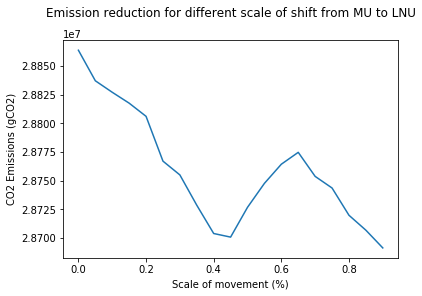

In [14]:
clus = df.copy()

move = np.arange(0, 0.95, 0.05)
result = [None]*len(move)

for i in range(len(result)): 

    c5 = clus[clus["Cluster"] == 0]

    c5["Change"] = move[i]*c5["consumption_kWh"]

    tot = c5['Change'].sum()


    c2 = clus[clus["Cluster"] == 1]
    tot_c2 = c2["consumption_kWh"].sum()

    c2["Perc"] = c2["consumption_kWh"]/tot_c2
    c2.head()
    c2["Perc"].sum()
    c2['Added'] = tot*c2["Perc"]
    c2.head()
    a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

    clus["Change"] = a

    clus["consumption_kWh1"] = clus["consumption_kWh"].where(
        clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
        clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

    a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]

    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

    result[i] = a["Emissions"].sum()

    
    
    
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Scale of movement (%)")
plt.title("Emission reduction for different scale of shift from MU to LNU",y=1.08)
plt.plot(move,result)
#ov_eff['CO2_intensity']

1, 3, 5 are the clusters with the most CO2 intensity per cluster, with sensibly same C intensity. C2 is the lowest. So shifting these to 2 could be positive. From the results it seems that the most interesting is the shift from c4 and c5 to 2. Both have the same maximum impact, but for cluster 4 it is reached for a smaller scale change


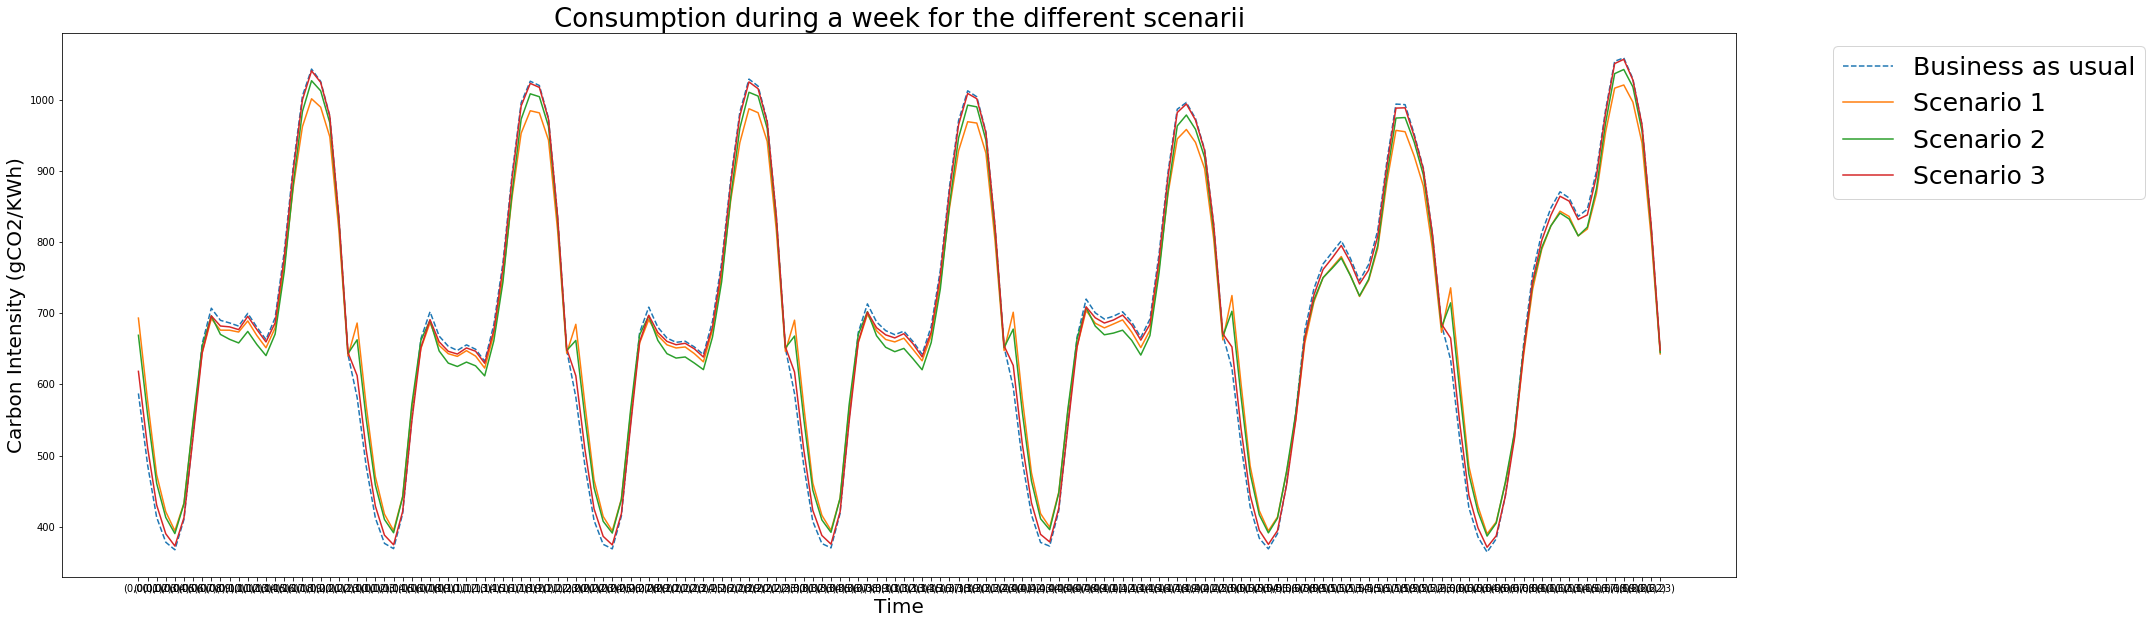

In [6]:
c = df.copy()
move = 0.25


#Senario 1
c_s1 = df.copy()
c5_s1 = c_s1[c_s1["Cluster"] == 4]

c5_s1["Change"] = move*c5_s1["consumption_kWh"]

tot_c5_s1 = c5_s1['Change'].sum()

c2_s1 = c_s1[c_s1["Cluster"] == 1]
tot_c2_s1 = c2_s1["consumption_kWh"].sum()

c2_s1["Perc"] = c2_s1["consumption_kWh"]/tot_c2_s1

c2_s1["Perc"].sum()
c2_s1['Added'] = tot_c5_s1*c2_s1["Perc"]
c2_s1.head()
a_s1 = [0]*168 + list(c2_s1["Added"]) + [0]*2*168 + list(c5_s1["Change"])

c_s1["Change"] = a_s1

c_s1["consumption_kWh1"] = c_s1["consumption_kWh"].where(
    c_s1["Cluster"] != 4, c_s1["consumption_kWh"]- c_s1["Change"]).where(
    c_s1["Cluster"] != 1, c_s1["consumption_kWh"] + c_s1["Change"])

grp_s1 = c_s1.groupby(c_s1.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
grp_s1["day"] = grp_s1.index.str[:1]
grp_s1["hour"] = grp_s1.index.str[1:]
grp_s1.index = "("+grp_s1["day"]+","+grp_s1["hour"]+")"
grp_s1['CO2_intensity'] = rf.predict(np.array(grp_s1[['consumption_kWh1','day','hour']], 
                dtype = pd.Series))



#Senario 2
c_s2 = df.copy()
c4_s2 = c_s2[c_s2["Cluster"] == 3]

c4_s2["Change"] = move*c4_s2["consumption_kWh"]

tot_c4_s2 = c4_s2['Change'].sum()

c2_s2 = c_s2[c_s2["Cluster"] == 1]
tot_c2_s2 = c2_s2["consumption_kWh"].sum()

c2_s2["Perc"] = c2_s2["consumption_kWh"]/tot_c2_s2

c2_s2["Perc"].sum()
c2_s2['Added'] = tot_c4_s2*c2_s2["Perc"]
c2_s2.head()
a_s2 = [0]*168 + list(c2_s2["Added"]) + [0]*2*168 + list(c4_s2["Change"])

c_s2["Change"] = a_s2

c_s2["consumption_kWh1"] = c_s2["consumption_kWh"].where(
    c_s2["Cluster"] != 4, c_s2["consumption_kWh"]- c_s2["Change"]).where(
    c_s2["Cluster"] != 1, c_s2["consumption_kWh"] + c_s2["Change"])

grp_s2 = c_s2.groupby(c_s2.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
grp_s2["day"] = grp_s2.index.str[:1]
grp_s2["hour"] = grp_s2.index.str[1:]
grp_s2.index = "("+grp_s2["day"]+","+grp_s2["hour"]+")"

grp_s2['CO2_intensity'] = rf.predict(np.array(grp_s2[['consumption_kWh1','day','hour']], 
                dtype = pd.Series))


#Senario 3
c_s3 = df.copy()
c1_s3 = c_s3[c_s3["Cluster"] == 0]

c1_s3["Change"] = move*c1_s3["consumption_kWh"]

tot_c1_s3 = c1_s3['Change'].sum()

c2_s3 = c_s3[c_s3["Cluster"] == 1]
tot_c2_s3 = c2_s3["consumption_kWh"].sum()

c2_s3["Perc"] = c2_s3["consumption_kWh"]/tot_c2_s3

c2_s3["Perc"].sum()
c2_s3['Added'] = tot_c1_s3*c2_s3["Perc"]
c2_s3.head()
a_s3 = [0]*168 + list(c2_s3["Added"]) + [0]*2*168 + list(c1_s3["Change"])

c_s3["Change"] = a_s3

c_s3["consumption_kWh1"] = c_s3["consumption_kWh"].where(
    c_s3["Cluster"] != 4, c_s3["consumption_kWh"]- c_s3["Change"]).where(
    c_s3["Cluster"] != 1, c_s3["consumption_kWh"] + c_s3["Change"])

grp_s3 = c_s3.groupby(c_s3.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
grp_s3["day"] = grp_s3.index.str[:1]
grp_s3["hour"] = grp_s3.index.str[1:]
grp_s3.index = "("+grp_s3["day"]+","+grp_s3["hour"]+")"
grp_s3['CO2_intensity'] = rf.predict(np.array(grp_s3[['consumption_kWh1','day','hour']], 
                dtype = pd.Series))


grp_s1['Emissions'] = grp_s1["consumption_kWh1"]*grp_s1["CO2_intensity"]
grp_s2['Emissions'] = grp_s2["consumption_kWh1"]*grp_s2["CO2_intensity"]
grp_s3['Emissions'] = grp_s3["consumption_kWh1"]*grp_s3["CO2_intensity"]


figure(figsize=(30,10))

b = c.groupby(c.index)["consumption_kWh"].apply(lambda x: np.sum(x)).to_frame()
b["day"] = b.index.str[:1]
b["hour"] = b.index.str[1:]
b.index = "("+b["day"]+","+b["hour"]+")"
plt.plot(b["consumption_kWh"], linestyle='dashed', label = "Business as usual")
plt.plot(grp_s1["consumption_kWh1"], label = "Scenario 1")
plt.plot(grp_s2["consumption_kWh1"], label = "Scenario 2")
plt.plot(grp_s3["consumption_kWh1"], label = "Scenario 3")
plt.title("Consumption during a week for the different scenarii",size = 26)
plt.xlabel("Time", size = "20")
plt.ylabel("Carbon Intensity (gCO2/KWh)", size = "20")
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 25})

plt.savefig("Consumption during a week for the different scenarii.png")

In [7]:
a.head()

,consumption_kWh,hour,CO2_intensity
time,,,
000,587.238769,0,206.339623
001,487.561051,1,214.980769
002,413.403647,2,214.673077
003,378.318955,3,215.509615
004,367.642231,4,216.461538


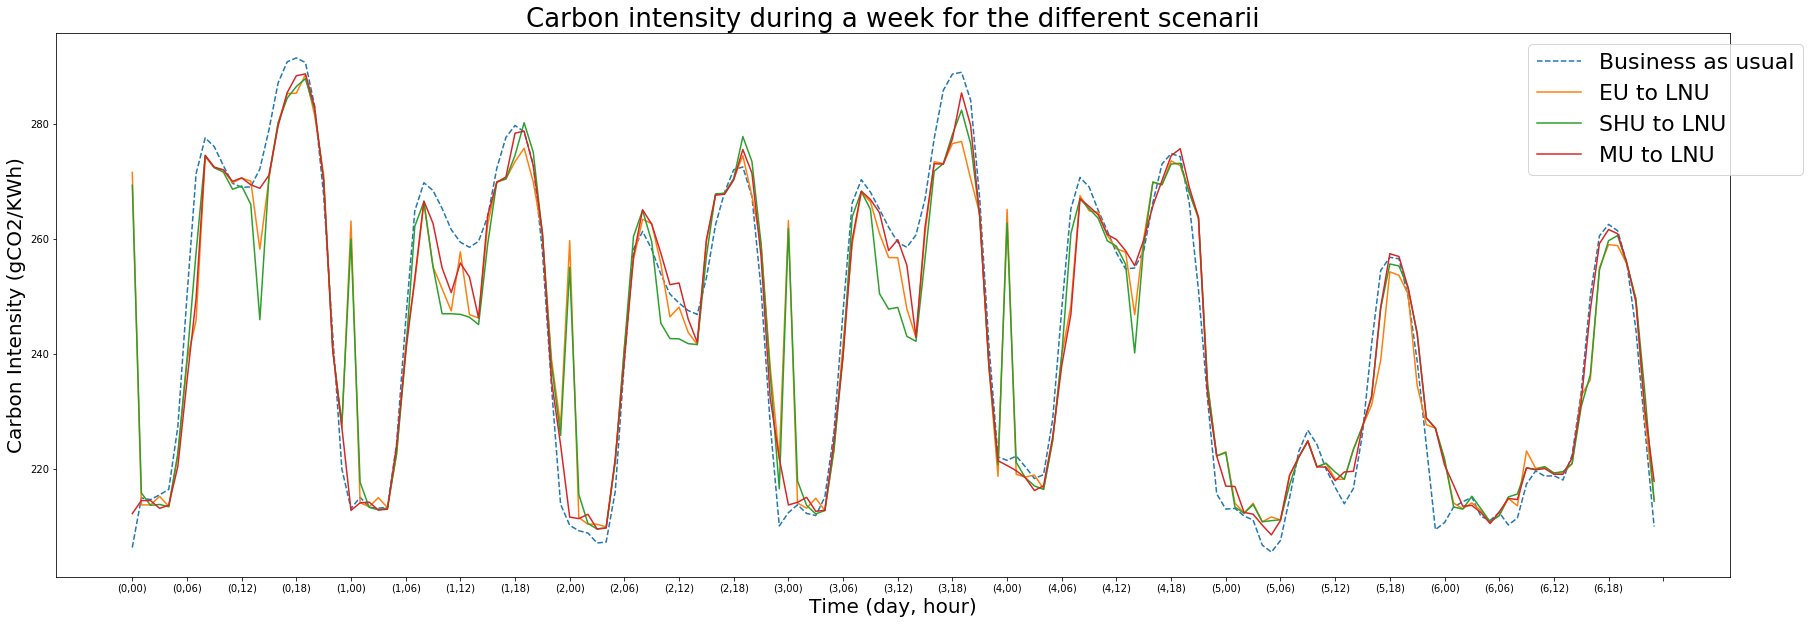

In [9]:
figure(figsize=(30,10))


a = pd.read_csv("../Data/London_intensity/Mean_intensities.csv")
plt.plot(a["Actual Carbon Intensity (gCO2/kWh)"],linestyle='dashed', label = "Business as usual")
plt.plot(grp_s1['CO2_intensity'], label = "EU to LNU")
plt.plot(grp_s2['CO2_intensity'], label = "SHU to LNU")
plt.plot(grp_s3['CO2_intensity'], label = "MU to LNU")
plt.title("Carbon intensity during a week for the different scenarii",size = 26)
plt.xticks(np.arange(0, len(grp_s1.index)+1, 6))
plt.xlabel("Time (day, hour)", size = "20")
plt.ylabel("Carbon Intensity (gCO2/KWh)", size = "20")
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 22})

plt.savefig("Carbon intensity during a week for the different scenarii 2.png", bbox_inches='tight')


In [14]:
grp_s1.index.astype(int)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            614, 615, 616, 617, 618, 619, 620, 621, 622, 623],
           dtype='int64', name='time', length=168)

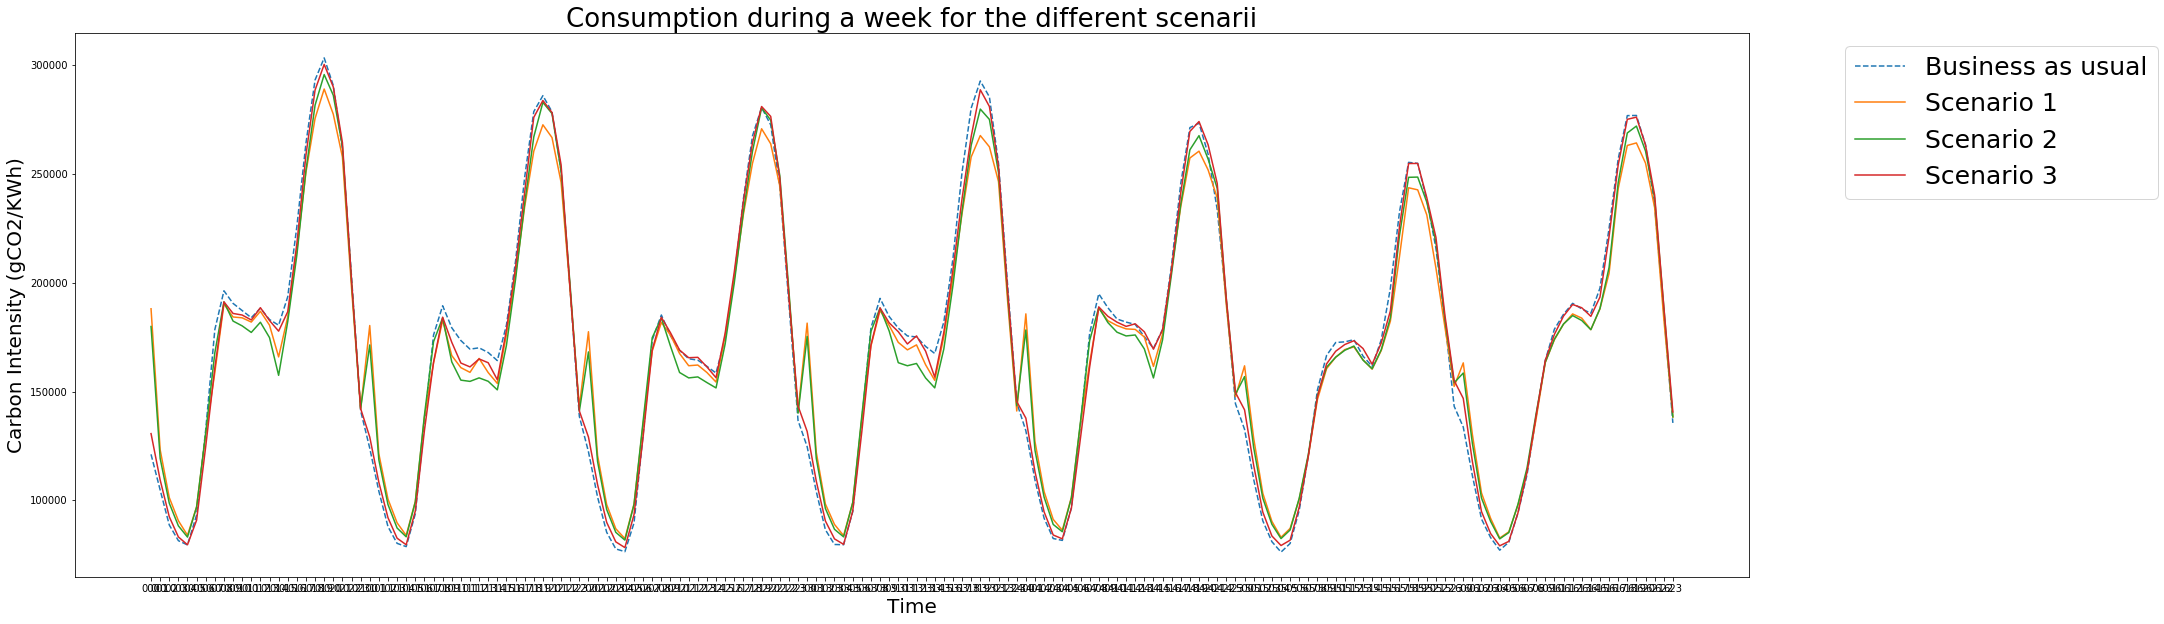

In [14]:
figure(figsize=(30,10))


c['Emissions'] = c["CO2_intensity"]*c["consumption_kWh"]

d = c.groupby(c.index)["Emissions"].apply(lambda x: np.sum(x)).to_frame()
plt.plot(d, linestyle='dashed', label = "Business as usual")
plt.plot(grp_s1["Emissions"], label = "Scenario 1")
plt.plot(grp_s2["Emissions"], label = "Scenario 2")
plt.plot(grp_s3["Emissions"], label = "Scenario 3")
plt.title("Consumption during a week for the different scenarii",size = 26)
plt.xlabel("Time", size = "20")
plt.ylabel("Carbon Intensity (gCO2/KWh)", size = "20")
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 25})

plt.savefig("Consumption during a week for the different scenarii.png")

In [13]:
d.head()

,Emissions
time,
000,121170.626044
001,104816.249852
002,88746.633006
003,81531.372512
004,79580.402876


In [12]:
clus = df.copy()

result = []
to = []
fro = []
for i in range(0,5): 
    for j in range(0,5): 

        c5 = clus[clus["Cluster"] == i]

        c5["Change"] = 0.4*c5["consumption_kWh"]

        tot = c5['Change'].sum()


        c2 = clus[clus["Cluster"] == j]
        tot_c2 = c2["consumption_kWh"].sum()

        c2["Perc"] = c2["consumption_kWh"]/tot_c2
        c2.head()
        c2["Perc"].sum()
        c2['Added'] = tot*c2["Perc"]
        c2.head()
        a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

        clus["Change"] = a

        clus["consumption_kWh1"] = clus["consumption_kWh"].where(
            clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
            clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

        a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
        a["day"] = a.index.str[:1]
        a["hour"] = a.index.str[1:]

        a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                        dtype = pd.Series))

        #ov_eff["CO2_intensity"]
        a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

        result.append(a["Emissions"].sum())
        to.append(j+1)
        fro.append(i+1)
        

        
res = pd.DataFrame(list(zip(result, to, fro)), columns =['Reduction','To','From']) 

In [13]:
res.head()
#res["Reduction"] = 107348424.81435384 -res["Reduction"]

,Reduction,To,From
0,2.888141e+07,1,1
1,2.873544e+07,2,1
2,2.882959e+07,3,1
3,2.886495e+07,4,1
4,2.884840e+07,5,1


In [14]:
er = res.pivot(index='To', columns='From', values='Reduction')

In [17]:
er = 28881412.133973893 - er
er

From,1,2,3,4,5
To,,,,,
1,0.000000,-8.708253e+04,-5.572587e+04,121052.893055,1.658499e+04
2,145967.377753,3.725290e-09,8.284622e+04,295733.847029,2.222958e+05
3,51817.175431,-1.002133e+05,3.725290e-09,146708.659614,6.396037e+04
4,16457.909017,-1.202576e+05,-1.668715e+05,0.000000,-6.980397e+04
5,33012.268669,-9.923827e+04,-4.223002e+04,105004.253618,3.725290e-09


In [18]:
er.max().max()

295733.84702916816

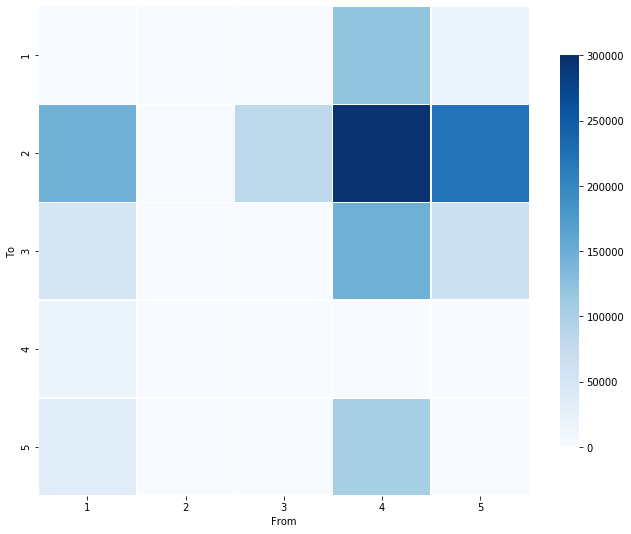

In [19]:
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
sns.heatmap(er, cmap="Blues", vmin= 0, vmax=300000,
           linewidth=0.3, cbar_kws={"shrink": .8})
plt.show()